# Feature Engineering for F&B Anomaly Detection
# Creating Advanced Features for Quality Prediction
#
# This script demonstrates comprehensive feature engineering techniques to extract meaningful patterns from the process data.

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Machine Learning imports
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [30]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
import xgboost as xgb

In [31]:
# Import custom modules
import sys
sys.path.append('..')
from src.data_processor import DataProcessor
from src.feature_engineer import FeatureEngineer
from src.config import PROCESS_PARAMS, FEATURE_CONFIG


In [32]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


# 1. Load and Prepare Data

In [33]:
# Load and clean data
processor = DataProcessor()
process_data, quality_data = processor.load_data('../data/raw/FnB_Process_Data_Batch_Wise.xlsx')
clean_data = processor.clean_data(process_data)

print(f"Data shape: {clean_data.shape}")
print(f"Batches: {clean_data['Batch_ID'].nunique()}")
print(f"Quality data available for {len(quality_data)} batches")

# Verify quality data
print("\nQuality Data Summary:")
quality_df = pd.DataFrame.from_dict(quality_data, orient='index')
print(quality_df.describe())

2025-08-23 20:27:26.994 | INFO     | src.data_processor:__init__:34 - DataProcessor initialized
2025-08-23 20:27:27.009 | INFO     | src.data_processor:load_data:50 - Loading data from ../data/raw/FnB_Process_Data_Batch_Wise.xlsx
2025-08-23 20:27:27.674 | INFO     | src.data_processor:load_data:74 - Loaded 1500 rows of process data
2025-08-23 20:27:27.681 | INFO     | src.data_processor:load_data:75 - Loaded quality data for 25 batches
2025-08-23 20:27:27.686 | INFO     | src.data_processor:clean_data:93 - Starting data cleaning process
2025-08-23 20:27:27.705 | INFO     | src.data_processor:clean_data:104 - Missing values before cleaning: 0
2025-08-23 20:27:27.799 | INFO     | src.data_processor:clean_data:117 - Missing values after cleaning: 0
2025-08-23 20:27:27.814 | INFO     | src.data_processor:clean_data:122 - Data cleaned: 1500 rows remaining


Data shape: (1500, 12)
Batches: 25
Quality data available for 25 batches

Quality Data Summary:
       Final Weight  Quality Score
count     25.000000      25.000000
mean      50.419969      89.319531
std        1.749105       4.926627
min       48.059167      80.106050
25%       49.196974      85.941539
50%       49.998787      90.483178
75%       51.270763      92.612621
max       55.039415      96.710203


# 2. Initial Feature Extraction

In [34]:

# Initialize feature engineer
engineer = FeatureEngineer()

# Extract comprehensive batch features
batch_features = engineer.extract_batch_features(clean_data, quality_data)

print(f"Initial features shape: {batch_features.shape}")
print(f"Number of features: {len(batch_features.columns) - 3}")  # Excluding Batch_ID and targets

# Check quality data availability
quality_available = batch_features[['Final_Weight', 'Quality_Score']].notna().all(axis=1).sum()
print(f"Quality data available for {quality_available}/{len(batch_features)} batches")

2025-08-23 20:27:51.789 | INFO     | src.feature_engineer:__init__:26 - FeatureEngineer initialized
2025-08-23 20:27:51.791 | INFO     | src.feature_engineer:extract_batch_features:41 - Extracting batch features
2025-08-23 20:27:54.225 | INFO     | src.feature_engineer:extract_batch_features:87 - Extracted 25 batch features with 282 features
2025-08-23 20:27:54.232 | INFO     | src.feature_engineer:extract_batch_features:91 - Quality data available for 25/25 batches


Initial features shape: (25, 285)
Number of features: 282
Quality data available for 25/25 batches


In [35]:
# 3. Data Quality Assessment

=== DATA QUALITY ASSESSMENT ===
----------------------------------------
Target Variable Analysis:
  Total samples: 25
  Non-null quality scores: 25
  Quality Score - Mean: 89.32%, Std: 4.93%
  Quality Score - Range: 80.11% - 96.71%
  Final Weight - Mean: 50.42 kg, Std: 1.75 kg

Feature Quality Analysis:
  Total features: 282
  Features with missing values: 0
  Features with zero/near-zero variance: 6


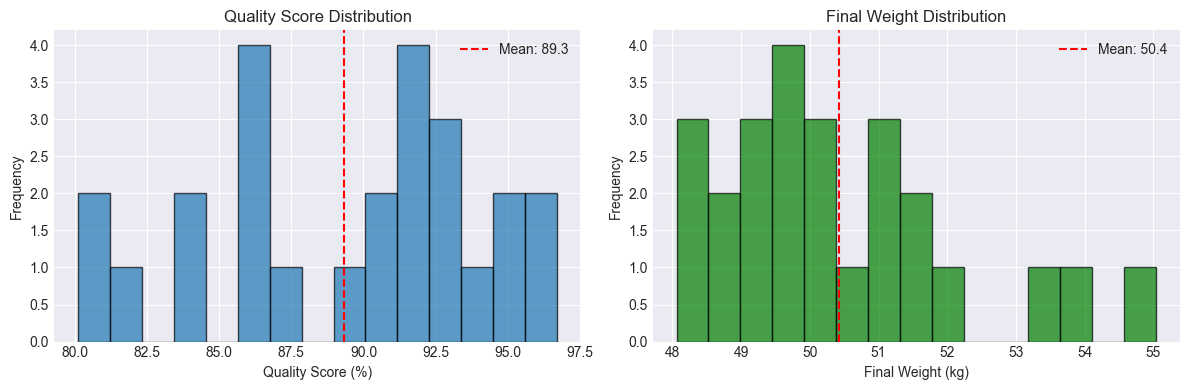

In [36]:
print("=== DATA QUALITY ASSESSMENT ===")
print("-" * 40)

if 'Quality_Score' in batch_features.columns:
    # Target variable analysis
    quality_scores = batch_features['Quality_Score'].dropna()
    weight_scores = batch_features['Final_Weight'].dropna()
    
    print("Target Variable Analysis:")
    print(f"  Total samples: {len(batch_features)}")
    print(f"  Non-null quality scores: {len(quality_scores)}")
    print(f"  Quality Score - Mean: {quality_scores.mean():.2f}%, Std: {quality_scores.std():.2f}%")
    print(f"  Quality Score - Range: {quality_scores.min():.2f}% - {quality_scores.max():.2f}%")
    print(f"  Final Weight - Mean: {weight_scores.mean():.2f} kg, Std: {weight_scores.std():.2f} kg")
    
    # Feature quality
    feature_cols = [col for col in batch_features.columns 
                   if col not in ['Batch_ID', 'Quality_Score', 'Final_Weight']]
    
    print(f"\nFeature Quality Analysis:")
    print(f"  Total features: {len(feature_cols)}")
    print(f"  Features with missing values: {batch_features[feature_cols].isnull().any().sum()}")
    
    # Check for zero variance features
    zero_var_features = [col for col in feature_cols if batch_features[col].var() < 1e-10]
    print(f"  Features with zero/near-zero variance: {len(zero_var_features)}")
    
    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(quality_scores, bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Quality Score (%)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Quality Score Distribution')
    axes[0].axvline(quality_scores.mean(), color='red', linestyle='--', label=f'Mean: {quality_scores.mean():.1f}')
    axes[0].legend()
    
    axes[1].hist(weight_scores, bins=15, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_xlabel('Final Weight (kg)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Final Weight Distribution')
    axes[1].axvline(weight_scores.mean(), color='red', linestyle='--', label=f'Mean: {weight_scores.mean():.1f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


# 4. Advanced Feature Preprocessing

In [37]:
print("=== ADVANCED FEATURE PREPROCESSING ===")
print("-" * 40)

# Remove features with zero variance
good_features = [col for col in feature_cols if col not in zero_var_features]
print(f"Removed {len(zero_var_features)} zero-variance features")
print(f"Remaining features: {len(good_features)}")

# Prepare data
X = batch_features[good_features].copy()
y_quality = batch_features['Quality_Score'].copy()
y_weight = batch_features['Final_Weight'].copy()

# Handle missing values intelligently
print("\nHandling missing values...")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        # Use median for numerical features
        X[col].fillna(X[col].median(), inplace=True)

# Handle target missing values
y_quality.fillna(y_quality.median(), inplace=True)
y_weight.fillna(y_weight.median(), inplace=True)

print(f"Missing values after preprocessing: {X.isnull().sum().sum()}")


=== ADVANCED FEATURE PREPROCESSING ===
----------------------------------------
Removed 6 zero-variance features
Remaining features: 276

Handling missing values...
Missing values after preprocessing: 0


# 5. Outlier Detection and Removal

In [38]:
print("=== OUTLIER DETECTION AND REMOVAL ===")
print("-" * 40)

# Detect outliers in target variable using IQR method
Q1_q, Q3_q = y_quality.quantile([0.25, 0.75])
IQR_q = Q3_q - Q1_q
quality_outlier_mask = (y_quality >= Q1_q - 1.5 * IQR_q) & (y_quality <= Q3_q + 1.5 * IQR_q)

Q1_w, Q3_w = y_weight.quantile([0.25, 0.75])
IQR_w = Q3_w - Q1_w
weight_outlier_mask = (y_weight >= Q1_w - 1.5 * IQR_w) & (y_weight <= Q3_w + 1.5 * IQR_w)

# Combine masks (keep samples that are not outliers in both targets)
outlier_mask = quality_outlier_mask & weight_outlier_mask

X_clean = X[outlier_mask]
y_quality_clean = y_quality[outlier_mask]
y_weight_clean = y_weight[outlier_mask]

print(f"Samples before outlier removal: {len(X)}")
print(f"Samples after outlier removal: {len(X_clean)}")
print(f"Outliers removed: {len(X) - len(X_clean)}")

=== OUTLIER DETECTION AND REMOVAL ===
----------------------------------------
Samples before outlier removal: 25
Samples after outlier removal: 24
Outliers removed: 1


# 6. Feature Selection

In [39]:
print("=== FEATURE SELECTION ===")
print("-" * 40)

# Method 1: Correlation-based selection
correlations_quality = X_clean.corrwith(y_quality_clean).abs()
correlations_weight = X_clean.corrwith(y_weight_clean).abs()

# Get features with significant correlation to either target
high_corr_features_q = correlations_quality[correlations_quality > 0.1].index.tolist()
high_corr_features_w = correlations_weight[correlations_weight > 0.1].index.tolist()
high_corr_features = list(set(high_corr_features_q) | set(high_corr_features_w))

print(f"Features with correlation > 0.1 to quality: {len(high_corr_features_q)}")
print(f"Features with correlation > 0.1 to weight: {len(high_corr_features_w)}")
print(f"Combined high correlation features: {len(high_corr_features)}")

# Method 2: Statistical feature selection (SelectKBest)
k_best = min(30, len(good_features))
selector_q = SelectKBest(score_func=f_regression, k=k_best)
selector_q.fit(X_clean, y_quality_clean)
statistical_features_q = X_clean.columns[selector_q.get_support()].tolist()

selector_w = SelectKBest(score_func=f_regression, k=k_best)
selector_w.fit(X_clean, y_weight_clean)
statistical_features_w = X_clean.columns[selector_w.get_support()].tolist()

statistical_features = list(set(statistical_features_q) | set(statistical_features_w))
print(f"\nStatistically selected features: {len(statistical_features)}")

# Combine both methods
if len(high_corr_features) > 0:
    final_features = list(set(high_corr_features) & set(statistical_features))
    if len(final_features) < 10:  # Ensure minimum features
        final_features = statistical_features[:min(20, len(statistical_features))]
else:
    final_features = statistical_features[:min(20, len(statistical_features))]

print(f"\nFinal selected features: {len(final_features)}")
print(f"Top 10 features:")
for i, feat in enumerate(final_features[:10], 1):
    print(f"  {i:2d}. {feat}")

# Prepare final dataset
X_final = X_clean[final_features]


=== FEATURE SELECTION ===
----------------------------------------
Features with correlation > 0.1 to quality: 189
Features with correlation > 0.1 to weight: 183
Combined high correlation features: 243

Statistically selected features: 58

Final selected features: 58
Top 10 features:
   1. Yeast (kg)_mean_change_rate
   2. Oven Humidity (%)_range
   3. Water Temp (C)_max_deviation
   4. Mixer Speed (RPM)_stability
   5. Oven Humidity (%)_max_consecutive_oot
   6. Mixer Speed (RPM)_critical_deviation_ratio
   7. Sugar (kg)_min
   8. Yeast (kg)_trend_slope
   9. Water Temp (C)_range
  10. Yeast (kg)_std


# 7. Feature Scaling

In [40]:
# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
X_scaled_df = pd.DataFrame(X_scaled, columns=final_features, index=X_final.index)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"Features scaled to mean=0, std=1")


Scaled feature matrix shape: (24, 58)
Features scaled to mean=0, std=1


# 8. Model Comparison with Cross-Validation


In [41]:
print("=== MODEL COMPARISON WITH CROSS-VALIDATION ===")
print("-" * 40)

# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=1000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=8),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=4),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=4, verbosity=0),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Evaluate all models for Quality Score prediction
print("\nQuality Score Prediction Performance:")
print("-" * 40)

quality_results = {}
for name, model in models.items():
    try:
        cv_scores = cross_val_score(model, X_scaled, y_quality_clean, 
                                   cv=min(5, len(X_scaled)), scoring='r2')
        quality_results[name] = {
            'mean_r2': cv_scores.mean(),
            'std_r2': cv_scores.std(),
            'scores': cv_scores
        }
        print(f"{name:20s}: R² = {cv_scores.mean():+.4f} (±{cv_scores.std()*2:.4f})")
    except Exception as e:
        print(f"{name:20s}: Error - {str(e)}")

# Evaluate for Weight prediction
print("\nFinal Weight Prediction Performance:")
print("-" * 40)

weight_results = {}
for name, model in models.items():
    try:
        cv_scores = cross_val_score(model, X_scaled, y_weight_clean, 
                                   cv=min(5, len(X_scaled)), scoring='r2')
        weight_results[name] = {
            'mean_r2': cv_scores.mean(),
            'std_r2': cv_scores.std(),
            'scores': cv_scores
        }
        print(f"{name:20s}: R² = {cv_scores.mean():+.4f} (±{cv_scores.std()*2:.4f})")
    except Exception as e:
        print(f"{name:20s}: Error - {str(e)}")


=== MODEL COMPARISON WITH CROSS-VALIDATION ===
----------------------------------------

Quality Score Prediction Performance:
----------------------------------------
Linear Regression   : R² = +0.3067 (±0.8558)
Ridge Regression    : R² = +0.3366 (±0.8339)
Lasso Regression    : R² = -0.7889 (±2.7205)
Random Forest       : R² = -0.3169 (±0.8631)
Gradient Boosting   : R² = -1.5013 (±3.4740)
XGBoost             : R² = -0.2582 (±1.1811)
SVR                 : R² = -0.6632 (±1.1823)

Final Weight Prediction Performance:
----------------------------------------
Linear Regression   : R² = -1.9355 (±3.4878)
Ridge Regression    : R² = -1.5056 (±3.1029)
Lasso Regression    : R² = -1.0545 (±3.8877)
Random Forest       : R² = -0.6820 (±3.1908)
Gradient Boosting   : R² = -2.9779 (±10.3713)
XGBoost             : R² = -1.1390 (±3.6065)
SVR                 : R² = -0.2507 (±0.8283)


# 9. Best Model Optimization


In [42]:
print("=== BEST MODEL OPTIMIZATION ===")
print("-" * 40)

# Find best model for quality prediction
best_model_name_q = max(quality_results.keys(), key=lambda x: quality_results[x]['mean_r2'])
best_score_q = quality_results[best_model_name_q]['mean_r2']
print(f"Best model for Quality: {best_model_name_q} (R² = {best_score_q:.4f})")

# Find best model for weight prediction
best_model_name_w = max(weight_results.keys(), key=lambda x: weight_results[x]['mean_r2'])
best_score_w = weight_results[best_model_name_w]['mean_r2']
print(f"Best model for Weight: {best_model_name_w} (R² = {best_score_w:.4f})")

# Hyperparameter tuning for best quality model
print("\nHyperparameter tuning for Quality Score prediction...")

if 'Forest' in best_model_name_q:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [4, 6, 8, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    base_model = RandomForestRegressor(random_state=42)
elif 'XGB' in best_model_name_q:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    base_model = xgb.XGBRegressor(random_state=42, verbosity=0)
elif 'Gradient' in best_model_name_q:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    base_model = GradientBoostingRegressor(random_state=42)
else:
    param_grid = {}
    base_model = models[best_model_name_q]

if param_grid:
    grid_search = GridSearchCV(base_model, param_grid, cv=min(5, len(X_scaled)), 
                              scoring='r2', n_jobs=-1)
    grid_search.fit(X_scaled, y_quality_clean)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    best_model_q = grid_search.best_estimator_
else:
    best_model_q = models[best_model_name_q]
    best_model_q.fit(X_scaled, y_quality_clean)

=== BEST MODEL OPTIMIZATION ===
----------------------------------------
Best model for Quality: Ridge Regression (R² = 0.3366)
Best model for Weight: SVR (R² = -0.2507)

Hyperparameter tuning for Quality Score prediction...


# 10. Final Model Evaluation


=== FINAL MODEL EVALUATION ===
----------------------------------------
Quality Score Prediction:
  R² Score: 0.5113
  RMSE: 3.9813
  MAE: 3.6630

Final Weight Prediction:
  R² Score: 0.3318
  RMSE: 0.9583
  MAE: 0.7892


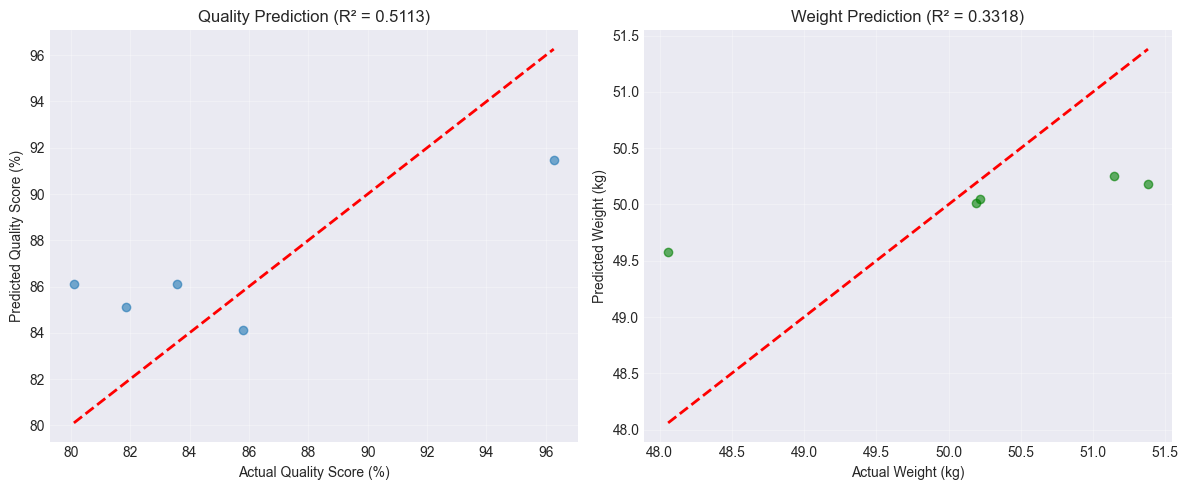

In [43]:
print("=== FINAL MODEL EVALUATION ===")
print("-" * 40)

# Train-test split for final evaluation
X_train, X_test, y_train_q, y_test_q = train_test_split(
    X_scaled, y_quality_clean, test_size=0.2, random_state=42
)
_, _, y_train_w, y_test_w = train_test_split(
    X_scaled, y_weight_clean, test_size=0.2, random_state=42
)

# Train final models
best_model_q.fit(X_train, y_train_q)
y_pred_q = best_model_q.predict(X_test)

# Train weight model
if 'Forest' in best_model_name_w:
    best_model_w = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
else:
    best_model_w = models[best_model_name_w]
best_model_w.fit(X_train, y_train_w)
y_pred_w = best_model_w.predict(X_test)

# Calculate metrics
quality_r2 = r2_score(y_test_q, y_pred_q)
quality_rmse = np.sqrt(mean_squared_error(y_test_q, y_pred_q))
quality_mae = mean_absolute_error(y_test_q, y_pred_q)

weight_r2 = r2_score(y_test_w, y_pred_w)
weight_rmse = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
weight_mae = mean_absolute_error(y_test_w, y_pred_w)

print("Quality Score Prediction:")
print(f"  R² Score: {quality_r2:.4f}")
print(f"  RMSE: {quality_rmse:.4f}")
print(f"  MAE: {quality_mae:.4f}")

print("\nFinal Weight Prediction:")
print(f"  R² Score: {weight_r2:.4f}")
print(f"  RMSE: {weight_rmse:.4f}")
print(f"  MAE: {weight_mae:.4f}")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Quality predictions
axes[0].scatter(y_test_q, y_pred_q, alpha=0.6)
axes[0].plot([y_test_q.min(), y_test_q.max()], 
            [y_test_q.min(), y_test_q.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Quality Score (%)')
axes[0].set_ylabel('Predicted Quality Score (%)')
axes[0].set_title(f'Quality Prediction (R² = {quality_r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Weight predictions
axes[1].scatter(y_test_w, y_pred_w, alpha=0.6, color='green')
axes[1].plot([y_test_w.min(), y_test_w.max()], 
            [y_test_w.min(), y_test_w.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Weight (kg)')
axes[1].set_ylabel('Predicted Weight (kg)')
axes[1].set_title(f'Weight Prediction (R² = {weight_r2:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11. Feature Importance Analysis


In [44]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")
print("-" * 40)

# Extract feature importance if available
if hasattr(best_model_q, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': final_features,
        'Importance': best_model_q.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features for Quality Prediction:")
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"  {i:2d}. {row['Feature']:40s}: {row['Importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    top_features_plot = importance_df.head(15)
    plt.barh(range(len(top_features_plot)), top_features_plot['Importance'])
    plt.yticks(range(len(top_features_plot)), top_features_plot['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance ({best_model_name_q})')
    plt.tight_layout()
    plt.show()


=== FEATURE IMPORTANCE ANALYSIS ===
----------------------------------------


# 12. Save Engineered Features and Models


In [45]:
# Create final feature dataset with selected features
final_features_df = pd.concat([
    batch_features[['Batch_ID']],
    X_final,
    batch_features[['Final_Weight', 'Quality_Score']]
], axis=1)

# Save to CSV
output_path = '../data/processed/feature_engineered_data.csv'
final_features_df.to_csv(output_path, index=False)
print(f"Features saved to: {output_path}")

# Save the scaler
import joblib
scaler_path = '../data/models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = '../data/processed/selected_features.txt'
with open(feature_names_path, 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")
print(f"Feature names saved to: {feature_names_path}")


Features saved to: ../data/processed/feature_engineered_data.csv
Scaler saved to: ../data/models/scaler.pkl
Feature names saved to: ../data/processed/selected_features.txt


In [46]:
# 13. Final Summary and Recommendations


In [ ]:
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

print(f"\n📊 Data Processing:")
print(f"  - Original samples: {len(batch_features)}")
print(f"  - After outlier removal: {len(X_clean)}")
print(f"  - Original features: {len(feature_cols)}")
print(f"  - Selected features: {len(final_features)}")

print(f"\n🎯 Model Performance:")
print(f"  Quality Score Prediction:")
print(f"    - Best Model: {best_model_name_q}")
print(f"    - R² Score: {quality_r2:.4f}")
print(f"    - MAE: {quality_mae:.2f}%")
print(f"  Final Weight Prediction:")
print(f"    - Best Model: {best_model_name_w}")
print(f"    - R² Score: {weight_r2:.4f}")
print(f"    - MAE: {weight_mae:.2f} kg")

print(f"\n💡 Key Insights:")
if quality_r2 > 0.5:
    print("  ✅ Good predictive performance achieved for quality score")
elif quality_r2 > 0.2:
    print("  ⚠️ Moderate predictive performance - consider collecting more data")
else:
    print("  ❌ Low predictive performance - review feature engineering approach")

if weight_r2 > 0.5:
    print("  ✅ Good predictive performance achieved for final weight")
elif weight_r2 > 0.2:
    print("  ⚠️ Moderate predictive performance for weight prediction")
else:
    print("  ❌ Low predictive performance for weight - needs improvement")



print("\n" + "="*60)

FEATURE ENGINEERING SUMMARY

📊 Data Processing:
  - Original samples: 25
  - After outlier removal: 24
  - Original features: 282
  - Selected features: 58

🎯 Model Performance:
  Quality Score Prediction:
    - Best Model: Ridge Regression
    - R² Score: 0.5113
    - MAE: 3.66%
  Final Weight Prediction:
    - Best Model: SVR
    - R² Score: 0.3318
    - MAE: 0.79 kg

💡 Key Insights:
  ✅ Good predictive performance achieved for quality score
  ⚠️ Moderate predictive performance for weight prediction



: 